In [1]:
import os 
import json
import torch
import warnings

from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from configs.PROBLEM_CONFIG import target_list_parser
from dataset import ClimatePhenoDataset
from model.architecture import PhenoFormer
from train import LitModel

warnings.filterwarnings('ignore')

/home/eco03/mambaforge/envs/climate-pheno/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load model weights 

In [2]:
# Helper Functions 

def _get_config_and_summary(path):
    summary_files = [f for f in os.listdir(path) if f.endswith('.json')]
    with open(path / summary_files[0]) as file:
        config = json.loads(file.read())
    return config

def _initialise_phenoformer(config):
    target_list = target_list_parser(config['target'])
    model = PhenoFormer(
         target_list=target_list,
        d_in=7,
        d_out=1,
        d_model=config['d_model'],
        nhead=config['nhead'],
        dim_feedforward=config['dim_feedforward'],
        n_layers=config['n_layers'],
        elevation=config['elevation'],
        latlon=config['latlon'],
    )
    model = LitModel(
        backbone=model,
        target_scaler=None,
        args=Namespace(**config)
    )
    return model, target_list

def _load_weights(model, path):
    weight_files = [f for f in os.listdir(path) if f.endswith('.ckpt')]
    weight_path = path / weight_files[0]

    checkpoint = torch.load(weight_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.target_scaler = checkpoint['hyper_parameters']['target_scaler']
    
    return model 

def load_model(path):
    config = _get_config_and_summary(path)
    phenoformer, target_list = _initialise_phenoformer(config)
    phenoformer = _load_weights(phenoformer, path)
    return phenoformer , target_list
    

In [3]:
# Specify the path to one of the configurations (i.e. one of the subfolders of the "pre-trained-weights" folder)
path_to_model_folder = Path("./pre-trained-weights/MultiTask-phenoformer_default-LU+NE-uniformly_rdm-default/")

# Load model and set in evaluation mode 
trained_phenoformer, target_list = load_model(path_to_model_folder)
trained_phenoformer.eval()

print("Pre-trained PhenoFormer ready, list of predicted phases:")
print(target_list)

Pre-trained PhenoFormer ready, list of predicted phases:
['Small_leaved_lime:leaf_unfolding', 'Horse_chestnut:leaf_unfolding', 'Large_leaved_lime:leaf_unfolding', 'Common_rowan:leaf_unfolding', 'European_white_birch:leaf_unfolding', 'European_beech:leaf_unfolding', 'Hazel:leaf_unfolding', 'European_larch:needle_emergence', 'Common_spruce:needle_emergence']


# 2. Predictions 

In [4]:
dataset_folder = Path("/media/eco03/DATA/ClimatePhenoCH/")

dt = ClimatePhenoDataset(
    folder=dataset_folder,
    target_list=target_list,
)
data_loader = torch.utils.data.DataLoader(dt, batch_size=1, shuffle=True)

print(f"Dataset ready with {len(dt)} site-years")

Setting spring time range : [-101, 264]
Dataset ready with 6661 site-years


## 2.1 Visualise the input climate data for a random site-year

In [16]:
# Get a random sample 
data = data_loader.__iter__().__next__()

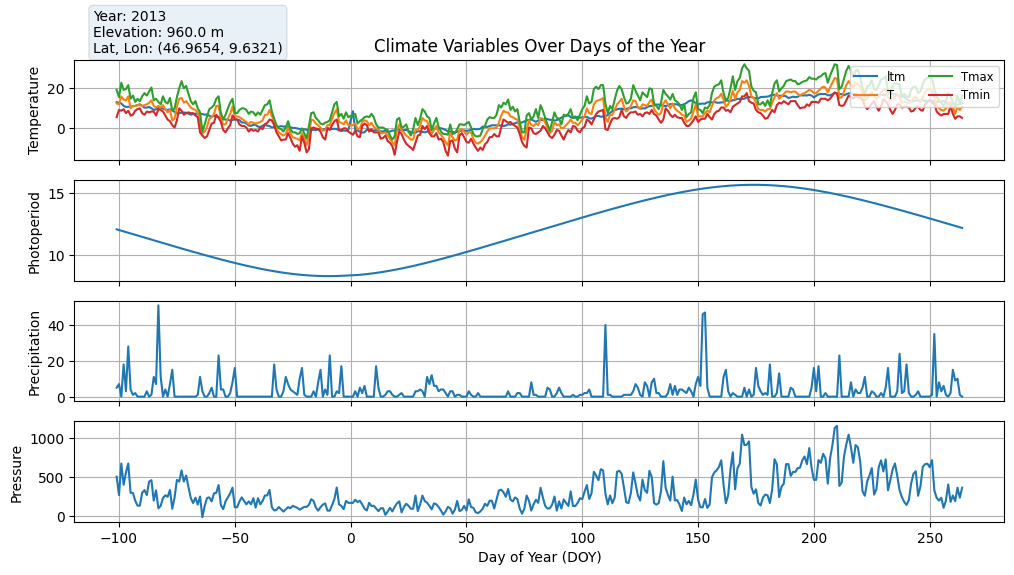

In [17]:
grouping = [1,0,2,0,0,0,3]

# Convert tensors to numpy for plotting
climate = data['climate'][0].numpy()
doys = data['doys'][0].numpy()
elevation = data['elevation'][0].item()
lat, lon = data['latlon'][0].numpy()
year = data['year'][0].item()

# Create the plot
fig, ax = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

# Plot each climate variable over the days of the year
for i in range(climate.shape[1]):
    climate_time_series = climate[:, i]
    variable_name = dt.var_names[i]
    mean= dt.norm_values[variable_name]['mean']
    std = dt.norm_values[variable_name]['std']
    
    climate_time_series = climate_time_series * std + mean # Un-normalise for visualisation
    
    ax[grouping[i]].plot(doys, climate_time_series, label=variable_name[:-1])

# Add static information as text on the plot
info_text = (
    f"Year: {int(year)}\n"
    f"Elevation: {elevation} m\n"
    f"Lat, Lon: ({lat:.4f}, {lon:.4f})"
)
ax[0].text(
    0.02, 1.5, info_text, 
    transform=ax[0].transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1)
)

# Add labels and legend
ax[0].set_title('Climate Variables Over Days of the Year')
ax[0].set_ylabel('Value')
ax[0].legend(loc='upper right', ncol=2, fontsize='small')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)



ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('Photoperiod')
ax[2].set_ylabel('Precipitation')
ax[3].set_ylabel('Pressure')
ax[3].set_xlabel('Day of Year (DOY)')





# Show plot
plt.show()


## 2.2 Get PhenoFormer predictions

In [18]:
## Get the predictions of PhenoFormer on that sample 
with torch.no_grad():
    predicted_dates = trained_phenoformer.predict_unnormalised_dates(data)


In [19]:
## Get the target phenophase dates (from the Swiss Phenology Network)
# and un-normalise them. 
target_dates = data['target']
unnormalised_target_dates = {}
for target_name in dt.target_list:
    if target_dates[target_name]==dt.nan_value_target:
        unnormalised_target_dates[target_name] = np.NaN
    else:
        mean, std = dt.target_scaler[target_name]
        unnormalised_target = target_dates[target_name] * std + mean 
        unnormalised_target_dates[target_name] = int(unnormalised_target)



In [20]:
## Show predicted vs True observed phenophase dates 
out = pd.DataFrame(index =dt.target_list, columns=['predicted', 'target'], dtype=float)
for idx in out.index:
    out.loc[idx] = [float(predicted_dates[idx].numpy()), unnormalised_target_dates[idx]]
    
out.round(1)

,predicted,target
Small_leaved_lime:leaf_unfolding,122.6,NaN
Horse_chestnut:leaf_unfolding,116.9,117.0
Large_leaved_lime:leaf_unfolding,122.8,NaN
Common_rowan:leaf_unfolding,117.8,116.0
European_white_birch:leaf_unfolding,118.5,116.0
European_beech:leaf_unfolding,122.1,121.0
Hazel:leaf_unfolding,118.6,111.0
European_larch:needle_emergence,117.8,116.0
Common_spruce:needle_emergence,137.3,131.0
